In [147]:
from pickle import load
import keras
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from random import *
import numpy as np
from numpy import argmax
import pydot
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [148]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
# Defined shared layers as global variables
repeator = RepeatVector(ger_length)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [150]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    
    sentences= []
    
    for i in range(len(source)):

        prediction = model.predict(source, verbose=0)[i]
        integers = [argmax(vector) for vector in prediction]
        target = list()
        for i in integers:
            word = word_for_id(i, tokenizer)
            if word is None:
                break
            target.append(word)
        sentence= ' '.join(target)
        sentences.append(sentence)
        
    return sentences


# Softmax activation function.
def softmax(x, axis=1):
    
# Arguments -
# x : Tensor.
# axis: Integer, axis along which the softmax normalization is applied.

# Returns-
# Tensor, output of softmax transformation.

# Raises-
# ValueError: In case `dim(x) == 1`.

    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        
 

In [151]:
# load datasets

# train has 9000 examples and test has 1000 examples
train = load_clean_sentences('E:\Machine translation project\Train_data.pkl')
test = load_clean_sentences('E:\Machine translation project\Test_data.pkl')
dataset = train +test

#Shuffling dataset as the sentences present in test data are larger in size
shuffle(dataset)
dataset = np.array(dataset)

# train on 9000 examples
train= dataset[:9000,:]

#test on remaining  1000 examples
test = dataset[9000:,:]

In [152]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
Xoh_train = encode_output(trainX, ger_vocab_size)
print(Xoh_train.shape)

trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
Yoh_train = encode_output(trainY, eng_vocab_size)
print(Yoh_train.shape)


# prepare testing data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
Xoh_test = encode_output(testX, ger_vocab_size)
print(Xoh_test.shape)

testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
Yoh_test = encode_output(testY, eng_vocab_size)
print(Yoh_test.shape)


English Vocabulary Size: 2214
English Max Length: 5
German Vocabulary Size: 3526
German Max Length: 9
(9000, 9, 3526)
(9000, 5, 2214)
(1000, 9, 3526)
(1000, 5, 2214)


In [153]:
# The following function Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
# "alphas" and the hidden states "a" of the Bi-LSTM.
    
# Input Arguments:
# a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
# s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
# Returns:
# context -- context vector, input of the next (post-attention) LSTM cell

def one_step_attention(a, s_prev):


    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    e = densor1(concat)
   
    energies = densor2(e)
   
    alphas = activator(energies)
    
    context = dotor([alphas,a])
    
    return context

In [154]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

#  post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense( eng_vocab_size, activation=softmax )

In [59]:
# The following function buids the model using the required layers.

# Input Arguments:
# Tx --                 length of the input sequence
# Ty --                 length of the output sequence
# n_a --                hidden state size of the Bi-LSTM
# n_s --                hidden state size of the post-attention LSTM

# human_vocab_size --   size of the python dictionary "human_vocab"
# machine_vocab_size -- size of the python dictionary "machine_vocab"

# Returns:
# model -- Keras model instance
    

def model( src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_a , n_s):
    

    X = Input(shape=(src_timesteps , src_vocab))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0

    outputs = []

    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    for t in range(tar_timesteps):
    
        context = one_step_attention(a,s)
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s,c])
        
        out =output_layer(s)
    
        outputs.append(out)
    
    model = Model(inputs=[X,s0,c0] , outputs=outputs)
    
    return model

In [60]:
model = model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 32,64)

In [68]:
adam = Adam(lr=0.1)
model.compile(optimizer=adam, loss='categorical_crossentropy')
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 9, 3526)      0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 9, 64)        911104      input_9[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 9, 64)        0           s0[0][0]                         
                                                                 lstm_5[20][0]                    
          

In [69]:
s0 = np.zeros((9000, n_s))
c0 = np.zeros((9000, n_s))
outputs = list(Yoh_train.swapaxes(0,1))

In [70]:
history = model.fit([Xoh_train, s0, c0], outputs, epochs=50 , batch_size=100)

Epoch 1/50
9000/9000 [==============================] - 13s 1ms/step - loss: 21.3591 - dense_5_loss: 0.4104
Epoch 2/50
9000/9000 [==============================] - 7s 735us/step - loss: 18.6681 - dense_5_loss: 0.0184
Epoch 3/50
9000/9000 [==============================] - 7s 729us/step - loss: 18.2446 - dense_5_loss: 0.0387
Epoch 4/50
9000/9000 [==============================] - 7s 742us/step - loss: 15.3955 - dense_5_loss: 0.0240
Epoch 5/50
9000/9000 [==============================] - 7s 737us/step - loss: 13.6616 - dense_5_loss: 0.0190
Epoch 6/50
9000/9000 [==============================] - 7s 744us/step - loss: 12.6987 - dense_5_loss: 0.0093
Epoch 7/50
9000/9000 [==============================] - 7s 741us/step - loss: 11.9074 - dense_5_loss: 0.0126
Epoch 8/50
9000/9000 [==============================] - 7s 731us/step - loss: 11.3586 - dense_5_loss: 0.0119
Epoch 9/50
9000/9000 [==============================] - 7s 733us/step - loss: 10.8713 - dense_5_loss: 0.0096
Epoch 10/50
9000/900

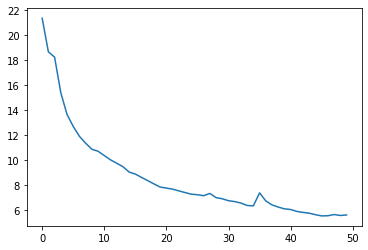

In [71]:
#plotting learning curve
plt.plot(history.history['loss'])

In [186]:
# predicting output over an input.

a = encode_sequences(ger_tokenizer, ger_length, [ 'geh'])
a

array([[62,  0,  0,  0,  0,  0,  0,  0,  0]])

In [187]:
a = encode_output(a, ger_vocab_size)
b = model.predict([a,s0,c0])
b

[array([[7.86866804e-06, 2.87491506e-08, 1.54940990e-05, ...,
         1.42489805e-11, 1.18787037e-11, 1.19909733e-11]], dtype=float32),
 array([[2.6664367e-02, 4.5792625e-04, 1.1609279e-06, ..., 1.9763270e-10,
         1.6798546e-10, 1.6205803e-10]], dtype=float32),
 array([[9.7948372e-01, 8.3463019e-06, 2.6143532e-08, ..., 1.5378759e-11,
         1.3973919e-11, 1.7836134e-11]], dtype=float32),
 array([[9.8613495e-01, 8.9586856e-06, 4.6248432e-11, ..., 5.0200535e-16,
         4.5589696e-16, 4.3257411e-16]], dtype=float32),
 array([[9.9997807e-01, 4.6859254e-09, 2.3359342e-16, ..., 5.5418160e-17,
         5.1923292e-17, 5.8133142e-17]], dtype=float32)]

In [179]:
#prediction

b = predict_sequence(model, eng_tokenizer , [a,s0,c0])
b

['go', 'out', '']